<a href="https://colab.research.google.com/github/linhlinhle997/object-detection-techniques/blob/features%2Fod-part1/class_bbox_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification + Bounding Box Regression

In [1]:
import kagglehub
import shutil
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models.resnet import ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Download Dataset

In [2]:
dataset = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
data_dir = "/content/dog-and-cat-detection"
shutil.move(dataset, data_dir)

100%|██████████| 1.03G/1.03G [00:11<00:00, 96.4MB/s]

Extracting files...


'/content/dog-and-cat-detection'

In [3]:
!cat /content/dog-and-cat-detection/annotations/Cats_Test736.xml


<annotation>
    <folder>images</folder>
    <filename>Cats_Test736.png</filename>
    <size>
        <width>500</width>
        <height>466</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>49</xmin>
            <ymin>125</ymin>
            <xmax>111</xmax>
            <ymax>168</ymax>
        </bndbox>
    </object>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>397</xmin>
            <ymin>103</ymin>
            <xmax>451</xmax>
            <ymax>132</ymax>
        </bndbox>
    </object>
</annotation>

## Dataset and DataLoader Setup

In [15]:
class ImageDataset(Dataset):
    def __init__(self, annotation_dir, image_dir, transform=None):
        self.annotation_dir = annotation_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects() # Filter valid images

    def filter_images_with_multiple_objects(self):
        valid_images_files = []
        for image_name in os.listdir(self.image_dir):
            # Check if it's a file and get the corresponding annotation file
            if os.path.isfile(os.path.join(self.image_dir, image_name)):
                annotation_name = os.path.splitext(image_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotation_dir, annotation_name)

            # Add image if it has <=1 object
            if self.count_objects_in_annotation(annotation_path) <= 1:
                valid_images_files.append(image_name)
            else:
                print(f"{image_name} has more than one object.")
        return valid_images_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            # Parse XML and count objects
            tree = ET.parse(annotation_path)
            return len(tree.getroot().findall("object")) # Count objects
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        # Parse XML to extract object label
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label, bbox = None, None
        for obj in root.findall("object"):
            name = obj.find("name").text
            # If label is not set, take the first label (as the dataset has only one object)
            if label is None:
                label = name

                # Get bounding box coordinates
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                # Normalize bounding box coordinates to [0, 1]
                bbox = [xmin / image_width, ymin / image_height, xmax / image_width, ymax / image_height]

        # Map label to numeric value
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files) # Total number of valid images

    def __getitem__(self, idx):
        # Get image path and load it
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Get annotation path
        annotation_name = os.path.splitext(image_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotation_dir, annotation_name)

        # Get the label and bounding box from the annotation
        label, bbox = self.parse_annotation(annotation_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label, bbox

In [16]:
# Data directory
annotation_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({"image_name": image_files})
df.head()

,image_name
0,Cats_Test2285.png
1,Cats_Test1306.png
2,Cats_Test1098.png
3,Cats_Test1490.png
4,Cats_Test137.png


In [17]:
# Train - Val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, val_df.shape

((2948, 1), (738, 1))

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(
    annotation_dir,
    image_dir,
    transform=transform
)

val_dataset = ImageDataset(
    annotation_dir,
    image_dir,
    transform=transform
)

Cats_Test736.png has more than one object.
Cats_Test736.png has more than one object.


In [19]:
# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df["image_name"].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df["image_name"].values]

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

len(train_loader), len(val_loader)

(93, 24)

# Model 2 head

In [20]:
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_features = self.base_model.fc.in_features

        # Remove the original FC layer
        self.base_model.fc = nn.Identity()

        # Classification head (4 output classes)
        self.classifier = nn.Linear(self.num_features, 4)

        # Regression head for bounding box
        self.regression = nn.Linear(self.num_features, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x) # Classification output
        bbox_coords = torch.sigmoid(self.regression(x)) # Bounding box output
        return class_logits, bbox_coords

In [21]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

TwoHeadedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

## Training and Evaluation Metrics Visualization


In [23]:
def train_one_epoch(model, train_loader, criterion_class, criterion_bbox, optimizer, device):
    correct, total = 0, 0
    losses = []
    model.train()
    for data, targets, bboxes in train_loader:
        data, targets, bboxes = data.to(device), targets.to(device), bboxes.to(device)

        scores, pred_bboxes = model(data)

        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox # Combine losses
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predictions = scores.max(1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    avg_loss = np.mean(losses)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def evaluate(model, val_loader, criterion_class, criterion_bbox, device):
    losses = []
    correct, total = 0, 0
    model.eval()

    with torch.no_grad():
        for data, targets, bboxes in val_loader:
            data, targets, bboxes = data.to(device), targets.to(device), bboxes.to(device)

            scores, pred_bboxes = model(data)

            loss_class = criterion_class(scores, targets)
            loss_bbox = criterion_bbox(pred_bboxes, bboxes)
            loss = loss_class + loss_bbox # Combine losses
            losses.append(loss.item())

            _, predictions = scores.max(1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    avg_loss = np.mean(losses)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [24]:
num_epochs = 10
train_losses, val_losses = [], []
train_acces, val_acces = [], []

for epoch in range(num_epochs):
    # Train and Evaluation model
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion_class, criterion_bbox, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion_class, criterion_bbox, device)

    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acces.append(train_acc)
    val_acces.append(val_acc)

    # Print metrics for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10: Train Loss: 0.2609, Train Acc: 90.33%, Val Loss: 0.2544, Val Acc: 90.91%
Epoch 2/10: Train Loss: 0.1285, Train Acc: 96.34%, Val Loss: 0.2029, Val Acc: 91.99%
Epoch 3/10: Train Loss: 0.1947, Train Acc: 92.77%, Val Loss: 0.1795, Val Acc: 93.35%
Epoch 4/10: Train Loss: 0.0681, Train Acc: 97.63%, Val Loss: 0.1582, Val Acc: 95.52%
Epoch 5/10: Train Loss: 0.0593, Train Acc: 98.34%, Val Loss: 0.0805, Val Acc: 97.15%
Epoch 6/10: Train Loss: 0.0264, Train Acc: 99.39%, Val Loss: 0.1888, Val Acc: 93.89%
Epoch 7/10: Train Loss: 0.0882, Train Acc: 97.86%, Val Loss: 0.8394, Val Acc: 68.52%
Epoch 8/10: Train Loss: 0.1658, Train Acc: 93.96%, Val Loss: 0.1720, Val Acc: 94.03%
Epoch 9/10: Train Loss: 0.0591, Train Acc: 98.44%, Val Loss: 0.2310, Val Acc: 93.08%
Epoch 10/10: Train Loss: 0.1356, Train Acc: 95.59%, Val Loss: 0.1430, Val Acc: 94.17%


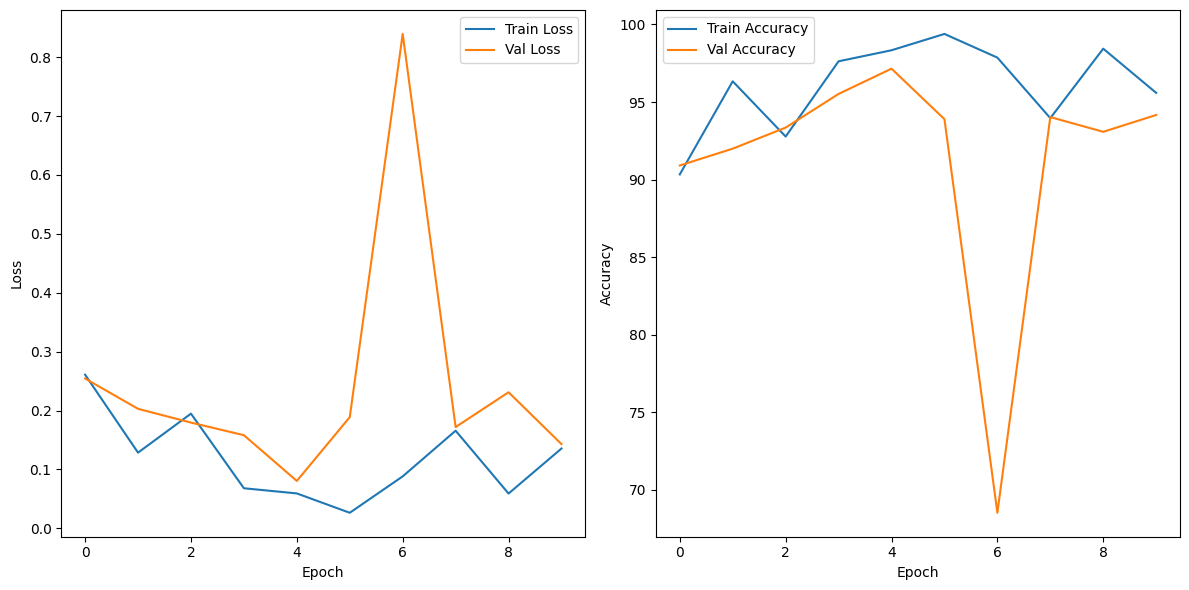

In [25]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acces, label="Train Accuracy")
plt.plot(val_acces, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Inference

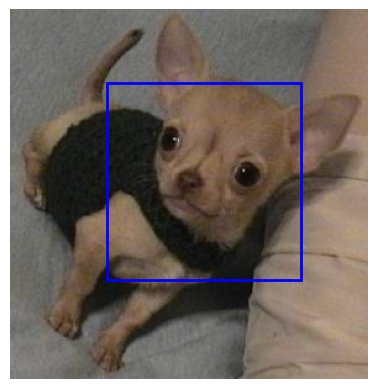

True Label: 1, Predicted Label: 1


In [54]:
def predict(model, val_dataset, device, image_dir):
    """Predict the label of a randomly selected image from the validation dataset."""
    # Randomly select an image from the dataset
    random_idx = random.randint(0, len(val_dataset) - 1)
    image_name = os.path.join(image_dir, val_dataset.image_files[random_idx])

    # Prepare the image and label
    image, label, bbox = val_dataset[random_idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension (1, C, H, W)

    # Prediction
    model.eval()
    with torch.no_grad():
        scores, pred_bboxes = model(image)
        _, pred_label = scores.max(1)

    # Get the predicted bounding box
    pred_bbox = pred_bboxes.squeeze(0).cpu().numpy()
    image_width, image_height = Image.open(image_name).size
    # Denormalize
    pred_bbox = [coord * (image_width if i % 2 == 0 else image_height) for i, coord in enumerate(pred_bbox)]

    # Plot the image and the predicted bounding box
    plt.imshow(Image.open(image_name))
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle(
        (pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1],
        linewidth=2, edgecolor='blue', facecolor='none'))
    plt.show()

    print(f"True Label: {label}, Predicted Label: {pred_label.item()}")
    return pred_label.item(), pred_bbox

predicted_label, predicted_bbox = predict(model, val_dataset, device, image_dir)